In [2]:
import mujoco
from pathlib import Path
import gym_lite6
import gymnasium as gym
import gym_lite6.env, gym_lite6.scripted_policy, gym_lite6.pickup_task
import mediapy as media
import numpy as np


In [3]:
model_path = Path(gym_lite6.__path__[0] + "/../models/lite6_gripper_wide.xml").resolve()
model_spec = mujoco.MjSpec.from_file(str(model_path))

obj_path = gym_lite6.__path__[0] + "/../models/cube_pickup_large.xml"
obj_spec = mujoco.MjSpec.from_file(obj_path)

scene_path = gym_lite6.__path__[0] + "/../models/scene.xml"
scene_spec = mujoco.MjSpec.from_file(scene_path)

In [ ]:
# This cell is just for inspecting the xml, no need to run
def print_bodies(parent, level=0):
  body = parent.first_body()
  while body:
    print(''.join(['-' for i in range(level)]) + body.name)
    print_bodies(body, level + 1)
    body = parent.next_body(body)
print_bodies(scene_spec.worldbody)
for site in scene_spec.sites:
  print(site.name)
for actuator in scene_spec.actuators:
  print(actuator.name)
# for i in range(env.unwrapped.model.njnt):
#     print(f"{i} {env.unwrapped.model.jnt(i)}")

In [4]:
frame = scene_spec.worldbody.add_frame()
frame.attach(model_spec, "", "-1")
frame.attach(obj_spec, "", "-1")

In [ ]:
# inspection of scene spec
print([(i, s.name) for i, s in enumerate(scene_spec.bodies)])
for attr in dir(scene_spec.compiler):
    if not attr.startswith("__"):
        print(attr, getattr(scene_spec.compiler, attr))
for attr in dir(scene_spec.option):
    if not attr.startswith("__"):
        print(attr, getattr(scene_spec.option, attr))

[(0, 'world'),
 (1, 'link_base-1'),
 (2, 'target-1'),
 (3, 'box-1'),
 (4, 'link1-1'),
 (5, 'link2-1'),
 (6, 'link3-1'),
 (7, 'link4-1'),
 (8, 'link5-1'),
 (9, 'link6-1'),
 (10, 'gripper_body-1'),
 (11, 'gripper_left_finger-1'),
 (12, 'gripper_right_finger-1')]

In [4]:
model = scene_spec.compile()
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

""

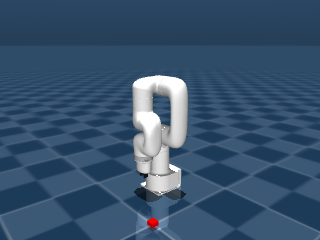

In [5]:
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.2
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)

mujoco.mj_forward(model, data)

renderer.update_scene(data, camera)
media.show_image(renderer.render())

""

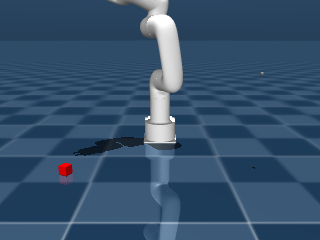

In [79]:
from importlib import reload

reload(gym_lite6.env)
reload(gym_lite6.utils)
reload(gym_lite6.scripted_policy)
reload(gym_lite6.pickup_task)

# task = gym_lite6.pickup_task.GraspTask('gripper_left_finger', 'gripper_right_finger', 'box', 'floor')
task = gym_lite6.pickup_task.GraspAndLiftTask('gripper_left_finger-1', 'gripper_right_finger-1', 'box-1', 'floor')

env = gym.make(
    "UfactoryCubePickup-v0",
    task=task,
    obs_type="pixels_state",
    max_episode_steps=300,
    visualization_width=320,
    visualization_height=240
)

observation, info = env.reset()
media.show_image(env.unwrapped.render(camera="side_cam-1"))


# 1: Create a dataset

In [ ]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.robot_devices.control_configs import RecordControlConfig
from PIL import Image

cfg = RecordControlConfig(
    repo_id="eufrizz/lite6_record_scripted_250204",
    single_task="Pick up the block",
    root="datasets/lite6_record_scripted_250204",
    fps=30,
    video=True,
    # push_to_hub=False
)

""" pusht features
From pusht dataset:

{'observation.image': {'dtype': 'video',
  'shape': (96, 96, 3),
  'names': ['height', 'width', 'channel'],
  'video_info': {'video.fps': 10.0,
   'video.codec': 'av1',
   'video.pix_fmt': 'yuv420p',
   'video.is_depth_map': False,
   'has_audio': False}},
 'observation.state': {'dtype': 'float32',
  'shape': (2,),
  'names': {'motors': ['motor_0', 'motor_1']}},
 'action': {'dtype': 'float32',
  'shape': (2,),
  'names': {'motors': ['motor_0', 'motor_1']}},
 'episode_index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'frame_index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'timestamp': {'dtype': 'float32', 'shape': (1,), 'names': None},
 'next.reward': {'dtype': 'float32', 'shape': (1,), 'names': None},
 'next.done': {'dtype': 'bool', 'shape': (1,), 'names': None},
 'next.success': {'dtype': 'bool', 'shape': (1,), 'names': None},
 'index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'task_index': {'dtype': 'int64', 'shape': (1,), 'names': None}}
"""

features={'action.qpos': {'dtype': 'float32',
  'shape': (6,)},
  'action.gripper': {'dtype': 'int8',
  'shape': (1,)},
 'observation.state.qpos': {'dtype': 'float32',
  'shape': (6,)},
 'observation.state.qvel': {'dtype': 'float32',
  'shape': (6,)},
  'observation.state.gripper': {'dtype': 'float32',
  'shape': (1,)},
 'observation.ee_pose.pos': {'dtype': 'float32',
  'shape': (3,)},
'observation.ee_pose.quat': {'dtype': 'float32',
  'shape': (4,)},
'observation.ee_pose.vel': {'dtype': 'float32',
  'shape': (3,)},
'observation.ee_pose.ang_vel': {'dtype': 'float32',
  'shape': (3,)},
 'observation.images.gripper': {'dtype': 'video',
  'shape': (240, 320, 3),
  'names': ['height', 'width', 'channels'],
  'info': None},
 'observation.images.side': {'dtype': 'video',
  'shape': (240, 320, 3),
  'names': ['height', 'width', 'channels'],
  'info': None},
   'episode_index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'frame_index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'timestamp': {'dtype': 'float32', 'shape': (1,), 'names': None},
 'reward': {'dtype': 'float32', 'shape': (1,), 'names': None},
 'index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'task_index': {'dtype': 'int64', 'shape': (1,), 'names': None}}

dataset = LeRobotDataset.create(
    cfg.repo_id,
    cfg.fps,
    root=cfg.root,
    features=features,
    use_videos=cfg.video,
    image_writer_processes=0,
    image_writer_threads=1,
)

In [13]:
from lerobot.common.robot_devices.robots.configs import MossRobotConfig
from lerobot.common.robot_devices.robots.utils import make_robot, make_robot_from_config
dummy_robot= make_robot("so100")
LeRobotDataset.create(
    cfg.repo_id,
    cfg.fps,
    root='datasets/dummy',
    robot=dummy_robot,
    use_videos=cfg.video,
    image_writer_processes=0,
    image_writer_threads=1,
).features


{'action': {'dtype': 'float32',
  'shape': (6,),
  'names': ['main_shoulder_pan',
   'main_shoulder_lift',
   'main_elbow_flex',
   'main_wrist_flex',
   'main_wrist_roll',
   'main_gripper']},
 'observation.state': {'dtype': 'float32',
  'shape': (6,),
  'names': ['main_shoulder_pan',
   'main_shoulder_lift',
   'main_elbow_flex',
   'main_wrist_flex',
   'main_wrist_roll',
   'main_gripper']},
 'observation.images.laptop': {'dtype': 'video',
  'shape': (480, 640, 3),
  'names': ['height', 'width', 'channels'],
  'info': None},
 'observation.images.phone': {'dtype': 'video',
  'shape': (480, 640, 3),
  'names': ['height', 'width', 'channels'],
  'info': None},
 'timestamp': {'dtype': 'float32', 'shape': (1,), 'names': None},
 'frame_index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'episode_index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'index': {'dtype': 'int64', 'shape': (1,), 'names': None},
 'task_index': {'dtype': 'int64', 'shape': (1,), 'names': None}}

In [95]:
policy = gym_lite6.scripted_policy.GraspAndLiftPolicy(env, 'end_effector-1', 'box-1', 'gripper_left_finger-1', 'gripper_right_finger-1', max_vel=0.2)
policy.reset()
observation, info = env.reset(seed=69, qpos=None, box_pos=None, box_quat=None)

step = 0
done = False
# ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}

while not done:
    # start_loop_t = time.perf_counter()

    action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)

    # delta = action["pos"] - observation["ee_pose"]["pos"]

    # # Quaternion error
    # quat_err = np.empty(4)
    # curr_quat = observation["ee_pose"]["quat"]
    # curr_quat_conj = np.empty(4)
    # ang_delta = np.empty(3)
    # mujoco.mju_negQuat(curr_quat_conj, curr_quat)
    # mujoco.mju_mulQuat(quat_err, action["quat"], curr_quat_conj)
    # mujoco.mju_quat2Vel(ang_delta, quat_err, 1.0)
    
    # # Convert to velocity (in world frame)
    # vel = Kp * delta * env.metadata["render_fps"]
    # ang_vel = Kp * ang_delta * env.metadata["render_fps"]
    # # Transform to end effector frame
    # action["qvel"] = env.unwrapped.solve_ik_vel(vel, ang_vel, ref_frame='end_effector', local=False)
    
    observation, reward, terminated, truncated, info = env.step(action)


    obs_dict = {}
    obs_dict["action.qpos"] = action["qpos"]
    obs_dict["action.gripper"] = action["gripper"]
    obs_dict["observation.state.qpos"] = observation["state"]["qpos"]
    obs_dict["observation.state.qvel"] = observation["state"]["qvel"]
    obs_dict["observation.state.gripper"] = observation["state"]["gripper"]
    obs_dict["observation.images.side"] = observation["pixels"]["side"]
    obs_dict["observation.images.gripper"] = observation["pixels"]["gripper"]
    obs_dict["observation.ee_pose.pos"] = observation["ee_pose"]["pos"]
    obs_dict["observation.ee_pose.quat"] = observation["ee_pose"]["quat"]
    obs_dict["observation.ee_pose.vel"] = observation["ee_pose"]["vel"]
    obs_dict["observation.ee_pose.ang_vel"] = observation["ee_pose"]["ang_vel"]
    obs_dict["reward"] = reward
    obs_dict["timestamp"] = env.unwrapped.data.time
    dataset.add_frame(obs_dict)

    if (policy.done):
      terminated = True
    print(f"{step=} {reward=} {terminated=}")
    done = terminated | truncated | done
    step += 1

dataset.image_writer.wait_until_done()
media.show_video([np.asarray(Image.open(p)) for p in dataset.episode_buffer['observation.images.side']], fps=env.metadata["render_fps"])

# if terminated:
#     print("Success!")
#     dataset.save_episode(cfg.single_task)
# else:
#     print(f"Failure! Reached {policy.stage}")
#     dataset.clear_episode_buffer()

# media.show_video(obs_dict["observation.images.gripper"], fps=env.metadata["render_fps"])

{0: {'start_time': 0.0, 'end_time': 2.8822975199130245, 'T_start': array([[-0.9717117 ,  0.19181336,  0.13778247,  0.25979616],
       [ 0.18313122,  0.98035476, -0.07326331, -0.18715091],
       [-0.14912858, -0.04595854, -0.9877492 ,  0.0337319 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'T_end': array([[ 1.        ,  0.        ,  0.        ,  0.35938421],
       [ 0.        , -1.        ,  0.        ,  0.18390729],
       [ 0.        ,  0.        , -1.        ,  0.048     ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'goal_pos': array([0.35938421, 0.18390729, 0.048     ]), 'goal_quat': array([0, 1, 0, 0])}}
step=0 reward=0 terminated=False
step=1 reward=0 terminated=False
step=2 reward=0 terminated=False
step=3 reward=0 terminated=False
step=4 reward=0 terminated=False
step=5 reward=0 terminated=False
step=6 reward=0 terminated=False
step=7 reward=0 terminated=False
step=8 reward=0 terminated=False
step=9 reward=0 terminated=False
step=10 re

In [41]:
dataset.clear_episode_buffer()

In [ ]:
cfg = RecordControlConfig(
    repo_id="eufrizz/lite6_record_scripted_250206",
    single_task="Pick up the block",
    root="datasets/lite6_record_scripted_250206",
    fps=env.metadata["render_fps"],
    video=True,
    # push_to_hub=False
)

def record_episodes_to_lerobot(env, policy, cfg, num_ep=1):
    dataset = LeRobotDataset.create(
        cfg.repo_id,
        cfg.fps,
        root=cfg.root,
        features=features,
        use_videos=cfg.video,
        image_writer_processes=0,
        image_writer_threads=1,
    )

    successful_trajectories = 0
    while successful_trajectories < num_ep:
        step = 0
        done = False
        policy.reset()
        observation, info = env.reset(seed=69, qpos=None, box_pos=None, box_quat=None)
        while not done:
            # start_loop_t = time.perf_counter()

            action = policy(env.unwrapped.model, env.unwrapped.data, observation, info)
            observation, reward, terminated, truncated, info = env.step(action)

            obs_dict = {}
            obs_dict["action.qpos"] = action["qpos"]
            obs_dict["action.gripper"] = action["gripper"]
            obs_dict["observation.state.qpos"] = observation["state"]["qpos"]
            obs_dict["observation.state.qvel"] = observation["state"]["qvel"]
            obs_dict["observation.state.gripper"] = observation["state"]["gripper"]
            obs_dict["observation.images.side"] = observation["pixels"]["side"]
            obs_dict["observation.images.gripper"] = observation["pixels"]["gripper"]
            obs_dict["observation.ee_pose.pos"] = observation["ee_pose"]["pos"]
            obs_dict["observation.ee_pose.quat"] = observation["ee_pose"]["quat"]
            obs_dict["observation.ee_pose.vel"] = observation["ee_pose"]["vel"]
            obs_dict["observation.ee_pose.ang_vel"] = observation["ee_pose"]["ang_vel"]
            obs_dict["reward"] = reward
            obs_dict["timestamp"] = env.unwrapped.data.time
            dataset.add_frame(obs_dict)

            if (policy.done):
                terminated = True
                print(f"{step=} {reward=} {terminated=}")
                done = terminated | truncated | done
                step += 1
        
        if terminated:
            print("Success!")
            successful_trajectories += 1
            dataset.save_episode(cfg.single_task)
            # dataset.image_writer.wait_until_done()
            # media.show_video([np.asarray(Image.open(p)) for p in dataset.episode_buffer['observation.images.side']], fps=env.metadata["render_fps"])

        else:
            # print(f"Failure! Reached {policy.stage}")
            print("Failed, retrying", policy.done, terminated)
            dataset.clear_episode_buffer()



policy = gym_lite6.scripted_policy.GraspAndLiftPolicy(env, 'end_effector-1', 'box-1', 'gripper_left_finger-1', 'gripper_right_finger-1', max_vel=0.2)
record_episodes_to_lerobot()
# media.show_video(obs_dict["observation.images.gripper"], fps=env.metadata["render_fps"])

In [59]:
dataset.encode_videos()

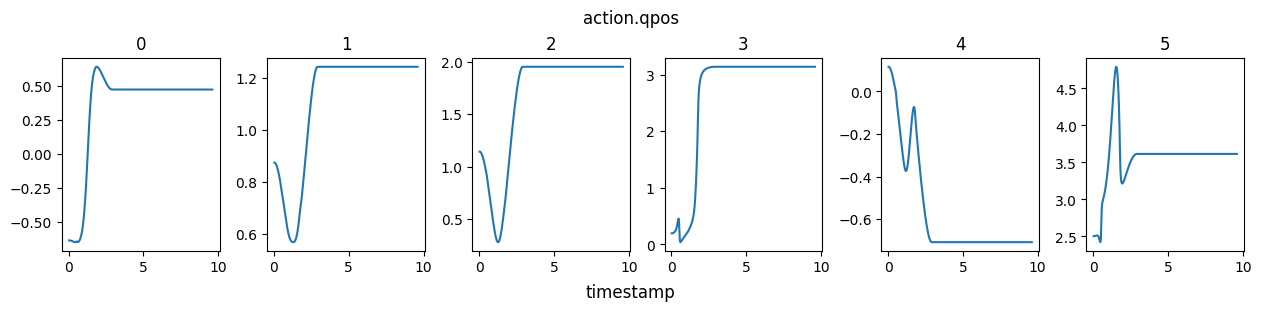

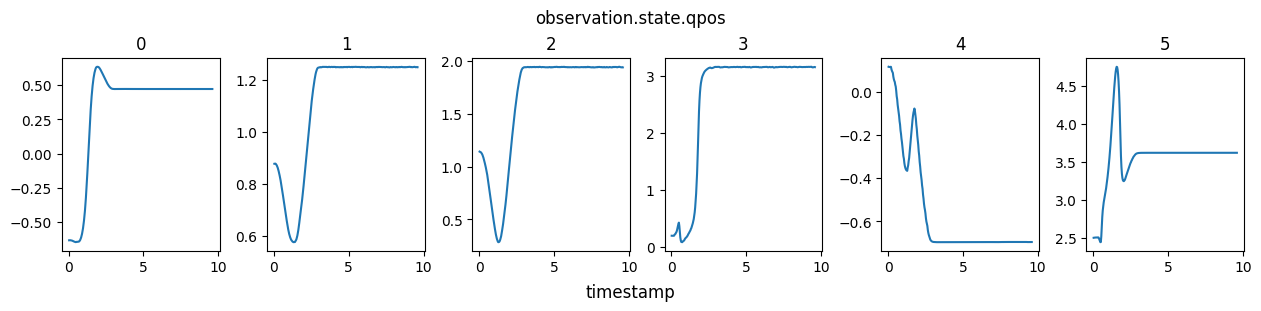

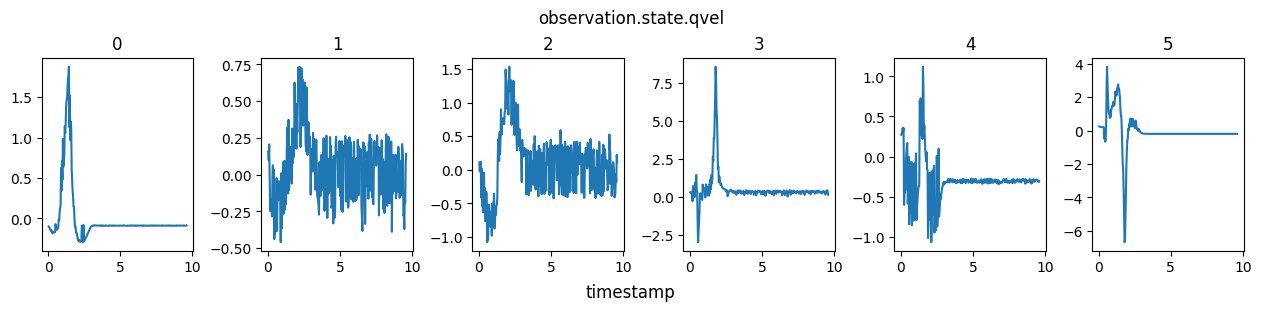

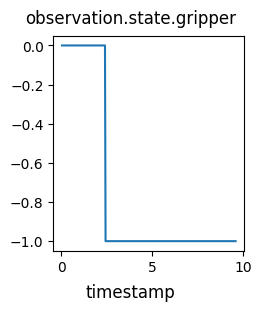

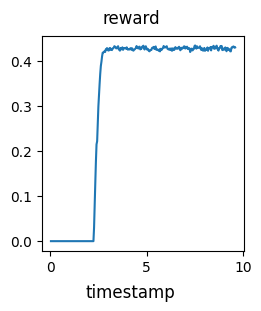

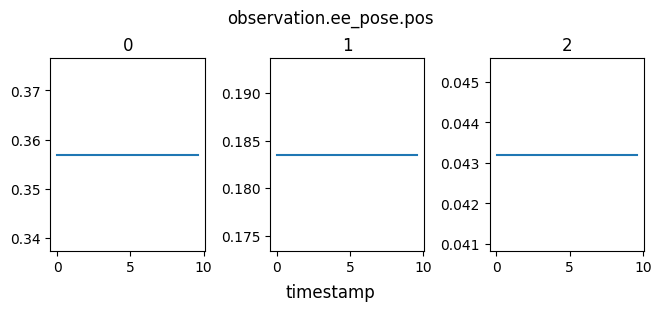

In [105]:

gym_lite6.utils.plot_dict_of_arrays(dataset.episode_buffer, "timestamp", keys=["action.qpos", "observation.state.qpos", "observation.state.qvel", "observation.state.gripper", "reward", "observation.ee_pose.pos"], sharey=False)


In [100]:
dataset.episode_buffer.keys()

dict_keys(['size', 'action.qpos', 'action.gripper', 'observation.state.qpos', 'observation.state.qvel', 'observation.state.gripper', 'observation.ee_pose.pos', 'observation.ee_pose.quat', 'observation.ee_pose.vel', 'observation.ee_pose.ang_vel', 'observation.images.gripper', 'observation.images.side', 'episode_index', 'frame_index', 'timestamp', 'reward', 'index', 'task_index'])

In [106]:
policy.goal_pos

AttributeError: 'GraspAndLiftPolicy' object has no attribute 'goal_pos'

# 2. Test dataset
Open loop replay

In [72]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset

delta_timestamps = {
    # Load the previous image and state at -0.1 seconds before current frame,
    # then load current image and state corresponding to 0.0 second.
    "observation.image": [-0.1, 0.0],
    "observation.state": [-0.1, 0.0],
    # Load the previous action (-0.1), the next action to be executed (0.0),
    # and 14 future actions with a 0.1 seconds spacing. All these actions will be
    # used to supervise the policy.
    "action": [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
}

dataset_name = "grasp_and_lift_random_50_2024-09-18_16-52-04"
# may need to change the metadata fps to 31.25 and increase the tolerance
dataset = LeRobotDataset("eufrizz/" + dataset_name,root="datasets/" + dataset_name, local_files_only=True, tolerance_s=2e-3)


Returning existing local_dir `datasets/grasp_and_lift_random_50_2024-09-18_16-52-04` as remote repo cannot be accessed in `snapshot_download` (None).
Returning existing local_dir `datasets/grasp_and_lift_random_50_2024-09-18_16-52-04` as remote repo cannot be accessed in `snapshot_download` (None).


Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
ep_idx = 0
from_idx = dataset.episode_data_index["from"][ep_idx].item()
to_idx = dataset.episode_data_index["to"][ep_idx].item()

observation, info = env.reset(qpos=dataset[from_idx]["action.qpos"])

step = 0
done = False
images = [observation["pixels"]["side"]]
# ep_dict = {"action.qpos": [], "action.gripper": [], "observation.state.qpos": [], "observation.state.qvel": [], "observation.state.gripper": [], "observation.pixels.side": [], "observation.pixels.gripper": [], "reward": [], "timestamp": [], "frame_index": [],}

for idx in range(from_idx, to_idx):
    # start_loop_t = time.perf_counter()
    frame = dataset[idx]
    # print(idx - from_idx)
    action = {"gripper": frame["action.gripper"].item(), "qpos": frame["action.qpos"]}
    observation, reward, terminated, truncated, info = env.step(action)
    images.append(observation["pixels"]["side"])

media.show_videos([images])
